In [1]:
import pandas as pd
import numpy as np
import gc
import sys
from sys import stdout
#sys.path.append(path+'/src/python/')
from time import time

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from seaborn.linearmodels import *

import xgboost as xgb

from sklearn.cross_validation import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 

path = './data/'
train_file = path + 'train.csv'
test_file = path + 'test.csv'

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file) 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)

test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

test_df.loc[1116, "GarageType"] = np.nan

lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

# Used to convert categorical features into ordinal numbers.
# (There's probably an easier way to do this, but it works.)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
def munge(df):
    all_df = pd.DataFrame(index = df.index)
   
    all_df["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        all_df.loc[idx, "LotFrontage"] = group.median()    

    all_df["LotArea"] = df["LotArea"]

    all_df["MasVnrArea"] = df["MasVnrArea"]
    all_df["MasVnrArea"].fillna(0, inplace=True)
   
    all_df["BsmtFinSF1"] = df["BsmtFinSF1"]
    all_df["BsmtFinSF1"].fillna(0, inplace=True)

    all_df["BsmtFinSF2"] = df["BsmtFinSF2"]
    all_df["BsmtFinSF2"].fillna(0, inplace=True)

    all_df["BsmtUnfSF"] = df["BsmtUnfSF"]
    all_df["BsmtUnfSF"].fillna(0, inplace=True)

    all_df["TotalBsmtSF"] = df["TotalBsmtSF"]
    all_df["TotalBsmtSF"].fillna(0, inplace=True)

    all_df["1stFlrSF"] = df["1stFlrSF"]
    all_df["2ndFlrSF"] = df["2ndFlrSF"]
    all_df["GrLivArea"] = df["GrLivArea"]
    
    all_df["GarageArea"] = df["GarageArea"]
    all_df["GarageArea"].fillna(0, inplace=True)

    all_df["WoodDeckSF"] = df["WoodDeckSF"]
    all_df["OpenPorchSF"] = df["OpenPorchSF"]
    all_df["EnclosedPorch"] = df["EnclosedPorch"]
    all_df["3SsnPorch"] = df["3SsnPorch"]
    all_df["ScreenPorch"] = df["ScreenPorch"]
    
    all_df["BsmtFullBath"] = df["BsmtFullBath"]
    all_df["BsmtFullBath"].fillna(0, inplace=True)

    all_df["BsmtHalfBath"] = df["BsmtHalfBath"]
    all_df["BsmtHalfBath"].fillna(0, inplace=True)

    all_df["FullBath"] = df["FullBath"] 
    all_df["HalfBath"] = df["HalfBath"] 
    all_df["BedroomAbvGr"] = df["BedroomAbvGr"] 
    all_df["KitchenAbvGr"] = df["KitchenAbvGr"] 
    all_df["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    all_df["Fireplaces"] = df["Fireplaces"] 

    all_df["GarageCars"] = df["GarageCars"]
    all_df["GarageCars"].fillna(0, inplace=True)

    all_df["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    all_df["OverallQual"] = df["OverallQual"]
    all_df["OverallCond"] = df["OverallCond"]

    # Quality measurements are stored as text but we can convert them to 
    # numbers where a higher number means higher quality.

    qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    all_df["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    all_df["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    all_df["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    all_df["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    all_df["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    all_df["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    all_df["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    all_df["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    all_df["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    all_df["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    all_df["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    all_df["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    all_df["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    all_df["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    all_df["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    all_df["YearBuilt"] = df["YearBuilt"]
    all_df["YearRemodAdd"] = df["YearRemodAdd"]

    all_df["GarageYrBlt"] = df["GarageYrBlt"]
    all_df["GarageYrBlt"].fillna(0.0, inplace=True)

    all_df["MoSold"] = df["MoSold"]
    all_df["YrSold"] = df["YrSold"]
    
    all_df["LowQualFinSF"] = df["LowQualFinSF"]
    all_df["MiscVal"] = df["MiscVal"]

    all_df["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    all_df["PoolArea"] = df["PoolArea"]
    all_df["PoolArea"].fillna(0, inplace=True)
    
    # Add categorical features as numbers too. It seems to help a bit.
    all_df = factorize(df, all_df, "MSSubClass")
    all_df = factorize(df, all_df, "MSZoning", "RL")
    all_df = factorize(df, all_df, "LotConfig")
    all_df = factorize(df, all_df, "Neighborhood")
    all_df = factorize(df, all_df, "Condition1")
    all_df = factorize(df, all_df, "BldgType")
    all_df = factorize(df, all_df, "HouseStyle")
    all_df = factorize(df, all_df, "RoofStyle")
    all_df = factorize(df, all_df, "Exterior1st", "Other")
    all_df = factorize(df, all_df, "Exterior2nd", "Other")
    all_df = factorize(df, all_df, "MasVnrType", "None")
    all_df = factorize(df, all_df, "Foundation")
    all_df = factorize(df, all_df, "SaleType", "Oth")
    all_df = factorize(df, all_df, "SaleCondition")

    # IR2 and IR3 don't appear that often, so just make a distinction
    # between regular and irregular.
    all_df["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # Most properties are level; bin the other possibilities together
    # as "not level".
    all_df["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # Most land slopes are gentle; treat the others as "not gentle".
    all_df["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # Most properties use standard circuit breakers.
    all_df["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # About 2/3rd have an attached garage.
    all_df["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # Most have a paved drive. Treat dirt/gravel and partial pavement
    # as "not paved".
    all_df["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # The only interesting "misc. feature" is the presence of a shed.
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
    all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
    
    # Did a remodeling happen in the year the house was sold?
    all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
    
    # Was this house sold in the year it was built?
    all_df["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

    all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1
    all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0) * 1
    all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1
    all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1
    all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1
    all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1
    all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1

    # These features actually lower the score a little.
    # all_df["HasBasement"] = df["BsmtQual"].isnull() * 1
    # all_df["HasGarage"] = df["GarageQual"].isnull() * 1
    # all_df["HasFireplace"] = df["FireplaceQu"].isnull() * 1
    # all_df["HasFence"] = df["Fence"].isnull() * 1

    # Months with the largest number of deals may be significant.
    all_df["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    all_df["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    all_df.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    all_df.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    all_df["Neighborhood_Good"].fillna(0, inplace=True)

    all_df["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    all_df["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    all_df["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    all_df["TotalArea"] = all_df[area_cols].sum(axis=1)

    all_df["TotalArea1st2nd"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]

    all_df["Age"] = 2010 - all_df["YearBuilt"]
    all_df["TimeSinceSold"] = 2010 - all_df["YrSold"]

    all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    all_df["YearsSinceRemodel"] = all_df["YrSold"] - all_df["YearRemodAdd"]
    
    # Simplifications of existing features into bad/average/good.
    all_df["SimplOverallQual"] = all_df.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplOverallCond"] = all_df.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    all_df["SimplPoolQC"] = all_df.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    all_df["SimplGarageCond"] = all_df.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplGarageQual"] = all_df.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFireplaceQu"] = all_df.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplFunctional"] = all_df.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    all_df["SimplKitchenQual"] = all_df.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplHeatingQC"] = all_df.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtFinType1"] = all_df.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtFinType2"] = all_df.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    all_df["SimplBsmtCond"] = all_df.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplBsmtQual"] = all_df.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterCond"] = all_df.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    all_df["SimplExterQual"] = all_df.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Bin by neighborhood (a little arbitrarily). Values were computed by: 
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    all_df["NeighborhoodBin"] = df["Neighborhood"].map(neighborhood_map)
    return all_df

train_df_munged = munge(train_df)
test_df_munged = munge(test_df)

print(train_df_munged.shape)
print(test_df_munged.shape)

# Copy NeighborhoodBin into a temporary DataFrame because we want to use the
# unscaled version later on (to one-hot encode it). 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = train_df_munged["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = test_df_munged["NeighborhoodBin"]

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != "object"].index

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
from scipy.stats import skew

skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Additional processing: scale the data.   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

################################################################################

# Convert categorical features using one-hot encoding.
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(["_" + column_name + "_" + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

def munge_onehot(df):
    onehot_df = pd.DataFrame(index = df.index)

    onehot_df = onehot(onehot_df, df, "MSSubClass", None, "40")
    onehot_df = onehot(onehot_df, df, "MSZoning", "RL", "RH")
    onehot_df = onehot(onehot_df, df, "LotConfig", None, "FR3")
    onehot_df = onehot(onehot_df, df, "Neighborhood", None, "OldTown")
    onehot_df = onehot(onehot_df, df, "Condition1", None, "RRNe")
    onehot_df = onehot(onehot_df, df, "BldgType", None, "2fmCon")
    onehot_df = onehot(onehot_df, df, "HouseStyle", None, "1.5Unf")
    onehot_df = onehot(onehot_df, df, "RoofStyle", None, "Shed")
    onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd", "CBlock")
    onehot_df = onehot(onehot_df, df, "Foundation", None, "Wood")
    onehot_df = onehot(onehot_df, df, "SaleType", "WD", "Oth")
    onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal", "AdjLand")

    # Fill in missing MasVnrType for rows that do have a MasVnrArea.
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None", "BrkCmn")

    # Also add the booleans from calc_df as dummy variables.
    onehot_df = onehot(onehot_df, df, "LotShape", None, "IR3")
    onehot_df = onehot(onehot_df, df, "LandContour", None, "Low")
    onehot_df = onehot(onehot_df, df, "LandSlope", None, "Sev")
    onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr", "FuseP")
    onehot_df = onehot(onehot_df, df, "GarageType", "None", "CarPort")
    onehot_df = onehot(onehot_df, df, "PavedDrive", None, "P")
    onehot_df = onehot(onehot_df, df, "MiscFeature", "None", "Othr")

    # Features we can probably ignore (but want to include anyway to see
    # if they make any positive difference).
    # Definitely ignoring Utilities: all records are "AllPub", except for
    # one "NoSeWa" in the train set and 2 NA in the test set.
    onehot_df = onehot(onehot_df, df, "Street", None, "Grvl")
    onehot_df = onehot(onehot_df, df, "Alley", "None", "Grvl")
    onehot_df = onehot(onehot_df, df, "Condition2", None, "PosA")
    onehot_df = onehot(onehot_df, df, "RoofMatl", None, "WdShake")
    onehot_df = onehot(onehot_df, df, "Heating", None, "Wall")

    # I have these as numerical variables too.
    onehot_df = onehot(onehot_df, df, "ExterQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "ExterCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "HeatingQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "KitchenQual", "TA", "Ex")
    onehot_df = onehot(onehot_df, df, "FireplaceQu", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageQual", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "GarageCond", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "PoolQC", "None", "Ex")
    onehot_df = onehot(onehot_df, df, "BsmtExposure", "None", "Gd")
    onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None", "GLQ")
    onehot_df = onehot(onehot_df, df, "Functional", "Typ", "Typ")
    onehot_df = onehot(onehot_df, df, "GarageFinish", "None", "Fin")
    onehot_df = onehot(onehot_df, df, "Fence", "None", "MnPrv")
    onehot_df = onehot(onehot_df, df, "MoSold", None, None)
    
    # Divide up the years between 1871 and 2010 in slices of 20 years.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None, None)
    onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None, None)

    return onehot_df

# Add the one-hot encoded categorical features.
onehot_df = munge_onehot(train_df)
onehot_df = onehot(onehot_df, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_df_munged = train_df_munged.join(onehot_df)

# These onehot columns are missing in the test data, so drop them from the
# training data or we might overfit on them.
drop_cols = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_df_munged.drop(drop_cols, axis=1, inplace=True)

onehot_df = munge_onehot(test_df)
onehot_df = onehot(onehot_df, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_df_munged = test_df_munged.join(onehot_df)

# This column is missing in the training data. There is only one example with
# this value in the test set. So just drop it.
test_df_munged.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns. They are either not very helpful or they cause overfitting.
drop_cols = [
    "_Condition2_PosN",    # only two are not zero
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df_munged.drop(drop_cols, axis=1, inplace=True)
test_df_munged.drop(drop_cols, axis=1, inplace=True)

################################################################################

# We take the log here because the error metric is between the log of the
# SalePrice and the log of the predicted price. That does mean we need to 
# exp() the prediction to get an actual sale price.
label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)

(1456, 111)
(1459, 111)
Training set size: (1456, 403)
Test set size: (1459, 403)


In [98]:
# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

xgb_regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

xgb_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_train_pred_xgb = xgb_regr.predict(train_df_munged)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_train_pred_xgb))

# Run prediction on the Kaggle test set.
y_test_pred_xgb = xgb_regr.predict(test_df_munged)

XGBoost score on training set:  0.0671731289779


In [6]:
label_df.columns.values

array(['SalePrice'], dtype=object)

In [7]:
## Xgboost gridsearch
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score

xtreme_forest = xgb.XGBRegressor()

parameter_grid = {
                 'max_depth' : [4,5,6],
                 'n_estimators':[100]
                 #'n_estimators': [200,210,240,250],
                 #'min_child_weight': [1,2,3,4]
                 }

cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=5)

grid_search_xgboost = GridSearchCV(xtreme_forest,
                           param_grid=parameter_grid,
                           scoring= "r2",
                           cv=cross_validation)

grid_search_xgboost.fit(train_df_munged, label_df)

print('Best score: {}'.format(grid_search_xgboost.best_score_))
print('Best parameters: {}'.format(grid_search_xgboost.best_params_))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Best score: 0.8655027391296536
Best parameters: {'max_depth': 4, 'n_estimators': 100}


In [10]:
grid_search_xgboost.best_score_

0.8655027391296536

In [95]:
from sklearn.linear_model import Lasso

# I found this best alpha through cross-validation.
best_alpha = 0.00099

lasso_regr = Lasso(alpha=best_alpha, max_iter=50000)
lasso_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_train_pred_lasso = lasso_regr.predict(train_df_munged)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_train_pred_lasso))

# Run prediction on the Kaggle test set.
y_test_pred_lasso = lasso_regr.predict(test_df_munged)

Lasso score on training set:  0.10155983007


In [97]:
## Random Forest

rf_regr = RandomForestRegressor(n_estimators=5000, max_depth=8, max_features='sqrt',min_samples_split=20,n_jobs=-1)
rf_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_train_pred_rf = rf_regr.predict(train_df_munged)
y_test = label_df
print("Random Forest score on training set: ", rmse(y_test, y_train_pred_rf))

# Run prediction on the Kaggle test set.
y_test_pred_rf = rf_regr.predict(test_df_munged)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest score on training set:  0.117486108576


Random Forests don't perform well with this dataset

In [28]:
# Extra Trees Regressor

et_regr = ExtraTreesRegressor(n_estimators=5000, max_depth=8, max_features='sqrt',n_jobs=-1)
et_regr.fit(train_df_munged, label_df)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = et_regr.predict(train_df_munged)
y_test = label_df
print("Extra Trees Regressor score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_et = et_regr.predict(test_df_munged)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Extra Trees Regressor score on training set:  0.112615570569


Extra Trees Regressor also no where in the range of performance of Lasso XGBoost

In [29]:
# Kernel Ridge GridSearch
from sklearn.kernel_ridge import KernelRidge

kridge_grid = KernelRidge()

parameter_grid = {
                 'alpha': [0.0001,0.001,0.01,0.1],
                 'degree': [1,2,3,4],
                 'kernel': ['polynomial']
                 #'n_estimators': [200,210,240,250],
                 #'min_child_weight': [1,2,3,4]
                 }

cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=10)

grid_search_kridge = GridSearchCV(kridge_grid,
                           param_grid=parameter_grid,
                           scoring= "neg_mean_squared_error",
                           cv=cross_validation)

grid_search_kridge.fit(train_df_munged, label_df)

print('Best score: {}'.format(grid_search_kridge.best_score_))
print('Best parameters: {}'.format(grid_search_kridge.best_params_))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Best score: -0.014468488187391585
Best parameters: {'kernel': 'polynomial', 'alpha': 0.1, 'degree': 2}


In [74]:
y_train_pred_kridge = grid_search_kridge.best_estimator_.predict(train_df_munged)
print("Kernel Ridge score on training set: ", rmse(label_df,y_train_pred_kridge))
y_test_pred_kridge = grid_search_kridge.best_estimator_.predict(test_df_munged)

Kernel Ridge score on training set:  0.060613080189


In [38]:
gbm_grid = GradientBoostingRegressor(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,6,8],
                 'n_estimators': [5000],
                 'min_samples_split':[5,10,15,20]
                 }

cross_validation = StratifiedKFold(label_df['SalePrice'], n_folds=5)

grid_search_gbm = GridSearchCV(gbm_grid,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search_gbm.fit(train_df_munged, label_df)

print('Best score: {}'.format(grid_search_gbm.best_score_))
print('Best parameters: {}'.format(grid_search_gbm.best_params_))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/val

Best score: 0.8828656408618457
Best parameters: {'min_samples_split': 15, 'max_depth': 4, 'n_estimators': 5000}


In [78]:
y_train_pred_gbm = grid_search_gbm.best_estimator_.predict(train_df_munged)
print("GBM score on training set: ", rmse(label_df,y_train_pred_gbm))
y_test_pred_gbm = grid_search_gbm.best_estimator_.predict(test_df_munged)

GBM score on training set:  0.000382064400006


In [101]:
y_pred_avg.shape

(1456, 1456)

In [207]:
## Analyzing the Weighting performances
## XGboost + Lasso + Kernel Ridge
rmse_arr = np.empty([5,5,5])

for wt_xgb in np.arange(0,5):
    for wt_lasso in np.arange(0,5):
        for wt_kridge in np.arange(0,5):
            if(wt_lasso + wt_kridge + wt_xgb == 0):
                rmse_arr[wt_xgb,wt_lasso,wt_kridge] = 0.1
                continue
            #for wt_gbm in np.arange(0,4):
            y_pred_avg = (wt_xgb*np.ravel(y_train_pred_xgb) + wt_lasso*np.ravel(y_train_pred_lasso) + wt_kridge*np.ravel(y_train_pred_kridge) + 0*np.ravel(y_train_pred_gbm))
            y_pred_avg = y_pred_avg / (wt_xgb + wt_lasso + wt_kridge)
            if rmse(label_df,y_pred_avg) < 0.0005:
                rmse_arr[wt_xgb,wt_lasso,wt_kridge] = 0.1
            else:    
                rmse_arr[wt_xgb,wt_lasso,wt_kridge] = rmse(label_df,y_pred_avg)
            print("RMSE Training Error for ::wt_xgb=%s, wt_lasso=%s, wt_kridge=%s:: = %s\n" %(str(wt_xgb), str(wt_lasso), str(wt_kridge), str(1000*rmse(label_df,y_pred_avg))))

RMSE Training Error for ::wt_xgb=0, wt_lasso=0, wt_kridge=1:: = 60.613080189

RMSE Training Error for ::wt_xgb=0, wt_lasso=0, wt_kridge=2:: = 60.613080189

RMSE Training Error for ::wt_xgb=0, wt_lasso=0, wt_kridge=3:: = 60.613080189

RMSE Training Error for ::wt_xgb=0, wt_lasso=0, wt_kridge=4:: = 60.613080189

RMSE Training Error for ::wt_xgb=0, wt_lasso=1, wt_kridge=0:: = 101.55983007

RMSE Training Error for ::wt_xgb=0, wt_lasso=1, wt_kridge=1:: = 78.7236626469

RMSE Training Error for ::wt_xgb=0, wt_lasso=1, wt_kridge=2:: = 71.9666685043

RMSE Training Error for ::wt_xgb=0, wt_lasso=1, wt_kridge=3:: = 68.8221691657

RMSE Training Error for ::wt_xgb=0, wt_lasso=1, wt_kridge=4:: = 67.0232167527

RMSE Training Error for ::wt_xgb=0, wt_lasso=2, wt_kridge=0:: = 101.55983007

RMSE Training Error for ::wt_xgb=0, wt_lasso=2, wt_kridge=1:: = 85.9807298579

RMSE Training Error for ::wt_xgb=0, wt_lasso=2, wt_kridge=2:: = 78.7236626469

RMSE Training Error for ::wt_xgb=0, wt_lasso=2, wt_kridge=

In [ ]:
## Lasso + Kernel Ridge Weight Analysis
rmse_arr = np.zeros([5,5])

for wt_lasso in np.arange(0,5):
    for wt_kridge in np.arange(0,5):
        if(wt_lasso + wt_kridge == 0):
            rmse_arr[wt_lasso,wt_kridge] = 0.1
            continue
        #for wt_gbm in np.arange(0,4):
        y_pred_avg = (wt_lasso*np.ravel(y_train_pred_lasso) + wt_kridge*np.ravel(y_train_pred_kridge))
        y_pred_avg = y_pred_avg / (wt_lasso + wt_kridge)
        rmse_arr[wt_lasso,wt_kridge] = rmse(label_df,y_pred_avg)
        print("RMSE Training Error for ::wt_lasso=%s, wt_kridge=%s:: = %s\n" %(str(wt_lasso), str(wt_kridge),  str(1000*rmse(label_df,y_pred_avg))))

101.55983007
60.613080189


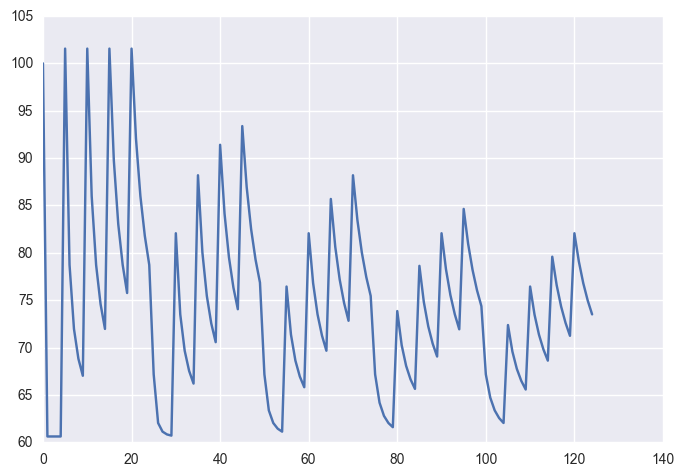

In [208]:
## Analyzing the error
ravel_rmse = 1000*np.ravel(rmse_arr)
ravel_rmse = ravel_rmse[ravel_rmse>1]
#sorted_rmse = sorted_rmse[sorted_rmse<100000]
print(np.max(ravel_rmse))
print(np.min(ravel_rmse))
plt.plot(ravel_rmse)#, np.linspace(0,1,sorted_rmse.size))

In [209]:
print(rmse_arr.shape)

print("Min = ", np.min(rmse_arr))
print(np.where(rmse_arr == np.min(rmse_arr)))

print("Max = ", np.max(rmse_arr))
print(np.where(rmse_arr == np.max(rmse_arr)))

(5, 5, 5)
Min =  0.060613080189
(array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([1, 2, 3, 4]))
Max =  0.10155983007
(array([0, 0, 0]), array([1, 2, 4]), array([0, 0, 0]))


In [211]:
np.where(rmse_arr == np.min(rmse_arr))

(array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([1, 2, 3, 4]))

In [214]:
y_final = (2*np.ravel(y_pred_xgb) + 3*np.ravel(y_test_pred_kridge) + 1*np.ravel(y_test_pred_lasso))/6
y_final.shape

(1459,)

In [15]:
def logloss(attempt, actual, epsilon=1.0e-15):
    """Logloss, i.e. the score of the bioresponse competition.
    """
    attempt = np.clip(attempt, epsilon, 1.0-epsilon)
    return - np.mean(actual * np.log(attempt) +
                     (1.0 - actual) * np.log(1.0 - attempt))

In [62]:
np.random.seed(0)  # seed to shuffle the train set

n_folds = 10
verbose = True
shuffle = False

X_ens = np.array(train_df_munged)
y_ens = np.array(label_df['SalePrice'])
X_submission = np.array(test_df_munged)

if shuffle:
    idx = np.random.permutation(y.size)
    X_ens = train_df_munged[idx]
    y_ens = targets_munged[idx]

skf = list(StratifiedKFold(y_ens, n_folds))

clfs = [lasso_regr,
        xgb_regr,
        #RandomForestRegressor(n_estimators=5000, max_depth=4, max_features='sqrt',n_jobs=-1),
        #ExtraTreesRegressor(n_estimators=5000, max_depth=4,n_jobs=-1),
        GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_features='sqrt',max_depth=4, n_estimators=5000),
        ]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [63]:
## Creating train and test sets for blending

dataset_blend_train = np.zeros((X_ens.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))

In [ ]:
for j, clf in enumerate(clfs):
    print(j, clf)
    dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
    for i, (train_curr, test_curr) in enumerate(skf):
        print("Fold", i)
        X_train = X_ens[train_curr]
        y_train = y_ens[train_curr]
        X_test = X_ens[test_curr]
        y_test = y_ens[test_curr]
        clf.fit(X_train, y_train)
        y_submission = clf.predict(X_test)
        dataset_blend_train[test_curr, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict(X_submission)
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

print ("Blending over.")

In [80]:
#y_final = np.mean(dataset_blend_test,axis=1)
from sklearn.kernel_ridge import KernelRidge
dd = KernelRidge()
dd.get_params()


{'alpha': 1,
 'coef0': 1,
 'degree': 3,
 'gamma': None,
 'kernel': 'linear',
 'kernel_params': None}

In [74]:
from sklearn.linear_model import Ridge, LinearRegression

linear_grid = LinearRegression()

parameter_grid = {
                 'fit_intercept': [True,False],
                 'normalize':[True,False]
                 #'n_estimators': [200,210,240,250],
                 #'min_child_weight': [1,2,3,4]
                 }

cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=5)

grid_search_linear = GridSearchCV(linear_grid,
                           param_grid=parameter_grid,
                           scoring= "r2",
                           cv=cross_validation)

grid_search_linear.fit(dataset_blend_train, y_ens)

print('Best score: {}'.format(grid_search_linear.best_score_))
print('Best parameters: {}'.format(grid_search_linear.best_params_))

#clf.fit(dataset_blend_train, y_ens)
#y_final = clf.predict(dataset_blend_test)

Best score: 0.8826642021596418
Best parameters: {'fit_intercept': False, 'normalize': True}


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [86]:
from sklearn.kernel_ridge import KernelRidge

kridge_grid = KernelRidge()

parameter_grid = {
                 'alpha': [0.0001,0.001,0.01,0.1],
                 'degree': [1,2,3,4],
                 'kernel': ['polynomial']
                 #'n_estimators': [200,210,240,250],
                 #'min_child_weight': [1,2,3,4]
                 }

cross_validation = StratifiedKFold(np.array(label_df['SalePrice']), n_folds=10)

grid_search_kridge = GridSearchCV(kridge_grid,
                           param_grid=parameter_grid,
                           scoring= "neg_mean_squared_error",
                           cv=cross_validation)

grid_search_kridge.fit(dataset_blend_train, y_ens)

print('Best score: {}'.format(grid_search_kridge.best_score_))
print('Best parameters: {}'.format(grid_search_kridge.best_params_))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Best score: -0.01805736864258649
Best parameters: {'kernel': 'polynomial', 'alpha': 0.1, 'degree': 2}


In [87]:
grid_search_kridge.grid_scores_

[mean: -0.01812, std: 0.00821, params: {'kernel': 'polynomial', 'alpha': 0.0001, 'degree': 1},
 mean: -0.02040, std: 0.00893, params: {'kernel': 'polynomial', 'alpha': 0.0001, 'degree': 2},
 mean: -0.02201, std: 0.00943, params: {'kernel': 'polynomial', 'alpha': 0.0001, 'degree': 3},
 mean: -0.02139, std: 0.00851, params: {'kernel': 'polynomial', 'alpha': 0.0001, 'degree': 4},
 mean: -0.01812, std: 0.00821, params: {'kernel': 'polynomial', 'alpha': 0.001, 'degree': 1},
 mean: -0.01883, std: 0.00843, params: {'kernel': 'polynomial', 'alpha': 0.001, 'degree': 2},
 mean: -0.02175, std: 0.00935, params: {'kernel': 'polynomial', 'alpha': 0.001, 'degree': 3},
 mean: -0.02367, std: 0.01011, params: {'kernel': 'polynomial', 'alpha': 0.001, 'degree': 4},
 mean: -0.01813, std: 0.00822, params: {'kernel': 'polynomial', 'alpha': 0.01, 'degree': 1},
 mean: -0.01808, std: 0.00821, params: {'kernel': 'polynomial', 'alpha': 0.01, 'degree': 2},
 mean: -0.02133, std: 0.00921, params: {'kernel': 'polynom

In [93]:
import pickle

ensemble_clfs_0106 = clfs

with open('0106_objs.pckl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([train_df_munged,test_df_munged,ensemble_clfs_0106,dataset_blend_test,dataset_blend_train], f)

In [88]:
y_final = grid_search_kridge.predict(dataset_blend_test)

In [215]:
y_pred = np.exp(y_final)

# Final Conversion.
output_file = 'xgboost_lasso_kridge_weights_2_1_3'
final_file = '0108_'+ output_file +'.csv'

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.shape
pred_df.to_csv(path+final_file, header=True, index_label='Id')

In [7]:
### We can improve it by CV and stacking  